# Minor Assignment 1

## Members (in pair):
- Yilun Wang / U84912213 / yilun830@bu.edu 
- Yipeng Guo / U17061528 / ypguo@bu.edu

The goal of the first two lectures was to familiarize you with manipulating and modifying the building blocks of Neural Networks in Keras to suit your needs.


In this assignment, use what you have learned to build a decision tree type neural net with 3 leaves or output nodes.


You can use a reduced version of the MNIST dataset with only 4 digits [0,1,2,7] and the model should first decide whether the image represents a [0 or 1] or [2 or 7] before further distinguishing between 0 and 1.


If you feel extra motivated you expand the model to also separate 2s from 7s.

In [118]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

In [119]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Use this function to extract the indices of a certain digit from the labels.
def digit_indices(digit, labels = train_labels):
    return np.where(labels==digit)

# Reshape and normalize the imag
train_images = train_images.reshape((60000, 28 * 28))
train_images = train_images.astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28))
test_images = test_images.astype("float32") / 255

### Model Building

Build a model that consists of 2 connected binary classifiers. The first classifier should take MNIST images of the digits in [0,1,2,7] ((784,)-shaped tensors) as input and make the first classification ([0,1] or [2,7])

The second classifier should take MNIST images and the result of the previous classification to further distinguish between 0s and 1s.

For extra credit you can add a 3rd classifier, similar to the 2nd one, to further distinguish 2s from 7s.

- You can use model subclassing to define a binary classifier model class.
- You can use layer subclassing to reduce the concat and relu/sigmoid layer combination into one custom layer.
- You can train the binary classifiers in stages or in conjunction.

Plese add a short paragraph explaining the model building decisions you make.

In [120]:
# input digits and defin train/test images and labels
digits = [0, 1, 2, 7]
train_digits = np.where(np.isin(train_labels,digits))[0]
train_images_new = train_images[train_digits]
train_labels_new = train_labels[train_digits]
test_digits = np.where(np.isin(test_labels,digits))[0]
test_images_new = test_images[test_digits]
test_labels_new = test_labels[test_digits]

In [121]:
# define our labels
def decision_labels(labels, d0, d1, other=[]):
    if other:
        x = 3
    else:
        x = 2
    num_samples = labels.shape[0]
    new_labels = np.zeros(shape=(num_samples, x))
    for i in range(num_samples):
        if labels[i] in d0:
            new_labels[i, 0] += 1
        elif labels[i] in d1:
            new_labels[i, 1] += 1
        else:
            new_labels[i, 2] += 1
    return new_labels

In [122]:
class tree_branch(keras.Model):
    def __init__(self, mask):
        super().__init__()
        self.cc = layers.Concatenate(axis=1)
        self.hl = layers.Dense(512, activation='relu')
        self.out = layers.Dense(3, activation='softmax')

    def call(self, inputs):
        output = self.cc(inputs)
        output = self.hl(output)
        output = self.out(output)
        return output

In [123]:
model_input = keras.Input(shape=(28*28))

In [124]:
# First model to classificate [0,1] or [2,7]
trainlabel_d0 = decision_labels(train_labels_new, [0,1], [2,7])
hl_d0 = layers.Dense(512, activation='relu')(model_input)
out_d0 = layers.Dense(2, activation='softmax')(hl_d0)

model_d0 = keras.Model(inputs = model_input,
                       outputs = out_d0,
                       name="D0")
# compile model
model_d0.compile(optimizer="adam",
                 loss="binary_crossentropy",
                 metrics=["binary_accuracy"])
# fit model
model_d0.fit(train_images_new, trainlabel_d0,
             validation_split=0.2,
             epochs=10,
             batch_size=128)

Epoch 1/10
156/156 [==============================] - 1s 5ms/step - loss: 0.0899 - binary_accuracy: 0.9723 - val_loss: 0.0350 - val_binary_accuracy: 0.9898
Epoch 2/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0296 - binary_accuracy: 0.9912 - val_loss: 0.0226 - val_binary_accuracy: 0.9928
Epoch 3/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0181 - binary_accuracy: 0.9942 - val_loss: 0.0176 - val_binary_accuracy: 0.9942
Epoch 4/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0123 - binary_accuracy: 0.9966 - val_loss: 0.0167 - val_binary_accuracy: 0.9944
Epoch 5/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0099 - binary_accuracy: 0.9972 - val_loss: 0.0154 - val_binary_accuracy: 0.9952
Epoch 6/10
156/156 [==============================] - 1s 4ms/step - loss: 0.0070 - binary_accuracy: 0.9982 - val_loss: 0.0137 - val_binary_accuracy: 0.9964
Epoch 7/10
156/156 [==============================] - 1s 4ms/ste

In [125]:
# Next model for discriminating 0,1
trainlabel_d00 = decision_labels(train_labels_new, [0], [1], [2,7])
d0 = keras.Input(shape=(2,))
model_d00 = tree_branch([model_input, d0])
# compile model
model_d00.compile(optimizer="adam",
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])
# fit model
model_d00.fit([train_images_new, trainlabel_d0], trainlabel_d00,
              epochs=10,
              batch_size=128)

Epoch 1/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0462 - accuracy: 0.9855
Epoch 2/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0041 - accuracy: 0.9990
Epoch 3/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0013 - accuracy: 0.9998
Epoch 4/10
195/195 [==============================] - 1s 3ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 5/10
195/195 [==============================] - 1s 3ms/step - loss: 3.9748e-04 - accuracy: 1.0000
Epoch 6/10
195/195 [==============================] - 1s 3ms/step - loss: 2.4456e-04 - accuracy: 1.0000
Epoch 7/10
195/195 [==============================] - 1s 3ms/step - loss: 1.2741e-04 - accuracy: 1.0000
Epoch 8/10
195/195 [==============================] - 1s 3ms/step - loss: 1.0579e-04 - accuracy: 1.0000
Epoch 9/10
195/195 [==============================] - 1s 3ms/step - loss: 8.3653e-05 - accuracy: 1.0000
Epoch 10/10
195/195 [==============================] - 1s 3ms/step - loss: 6.526

In [126]:
# model summary
model_d0.summary()

Model: "D0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_16 (InputLayer)       [(None, 784)]             0         
                                                                 
 dense_80 (Dense)            (None, 512)               401920    
                                                                 
 dense_81 (Dense)            (None, 2)                 1026      
                                                                 
Total params: 402,946
Trainable params: 402,946
Non-trainable params: 0
_________________________________________________________________


In [127]:
# model summary
model_d00.summary()

Model: "tree_branch_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 concatenate_21 (Concatenate  multiple                 0         
 )                                                               
                                                                 
 dense_82 (Dense)            multiple                  402944    
                                                                 
 dense_83 (Dense)            multiple                  1539      
                                                                 
Total params: 404,483
Trainable params: 404,483
Non-trainable params: 0
_________________________________________________________________


Put models together

In [128]:
# weights
d0_weights = [model_d0.layers[1].get_weights(), model_d0.layers[2].get_weights()]
d00_weights = [model_d00.layers[1].get_weights(), model_d00.layers[2].get_weights()]

In [129]:
# define model layers
hl1_d0d00 = layers.Dense(512, activation='relu', trainable=False)(model_input)
d0_d0d00 = layers.Dense(2, activation='softmax', trainable=False)(hl1_d0d00)
# concatenate layer
cc_d0d00 = layers.Concatenate(axis=1)([model_input, d0_d0d00])
hl2_d0d00 = layers.Dense(512, activation='relu', trainable=False)(cc_d0d00)
out_d0d00 = layers.Dense(3, activation='softmax', trainable=False)(hl2_d0d00)
model_d0d00 = keras.Model(inputs = model_input, outputs = out_d0d00)

# (784,)-shaped tensors
model_d0d00.build(input_shape=(784,))

model_d0d00.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_16 (InputLayer)          [(None, 784)]        0           []                               
                                                                                                  
 dense_84 (Dense)               (None, 512)          401920      ['input_16[0][0]']               
                                                                                                  
 dense_85 (Dense)               (None, 2)            1026        ['dense_84[0][0]']               
                                                                                                  
 concatenate_22 (Concatenate)   (None, 786)          0           ['input_16[0][0]',               
                                                                  'dense_85[0][0]']        

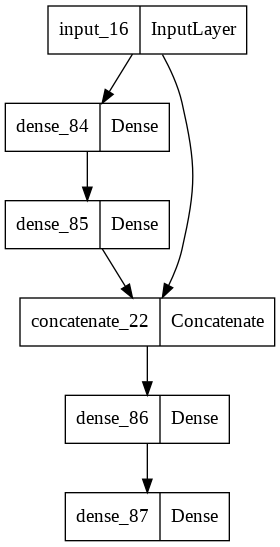

In [130]:
# plot model
keras.utils.plot_model(model_d0d00, "MNIST_split.png")

In [131]:
# set weights
model_d0d00.layers[1].set_weights(d0_weights[0])
model_d0d00.layers[2].set_weights(d0_weights[1])
model_d0d00.layers[4].set_weights(d00_weights[0])
model_d0d00.layers[5].set_weights(d00_weights[1])


test model on test data

In [132]:
model_d0d00.compile(optimizer="adam",
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])

test_labels_d00 = decision_labels(test_labels_new, [0], [1], [2,7])

model_d0d00.evaluate(test_images_new, test_labels_d00)

131/131 [==============================] - 1s 3ms/step - loss: 0.0395 - accuracy: 0.9943


[0.03949674963951111, 0.9942514896392822]

Accuracy is good!